# Open and analyse JM synthesis

In [1]:
%matplotlib notebook

import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import glob
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised
import scatcovjax.Scattering_lib as scatlib

import s2fft
import s2wav
import scatcovjax.plotting as plot

plot.notebook_plot_format()

## Load the healpix maps

In [11]:
nside = 128

# Target
f_target = np.load(f'/travail/lmousset/Cosmogrid_Hpx_map_nside{nside}_run0_idx10.npy')

# Synthesis
idx_synthesis = 2
f_end_list = glob.glob(f'/travail/jdelouis/synthe_S*_{nside}.npy')
print(f_end_list)
f_end = np.load(f_end_list[idx_synthesis])
f_end = hp.reorder(f_end, n2r=True) # Convert from nest to ring

['/travail/jdelouis/synthe_S011_128.npy', '/travail/jdelouis/synthe_S017_128.npy', '/travail/jdelouis/synthe_S015_128.npy', '/travail/jdelouis/synthe_S018_128.npy', '/travail/jdelouis/synthe_S019_128.npy', '/travail/jdelouis/synthe_S014_128.npy', '/travail/jdelouis/synthe_S012_128.npy', '/travail/jdelouis/synthe_S016_128.npy', '/travail/jdelouis/synthe_S013_128.npy', '/travail/jdelouis/synthe_S010_128.npy']


<IPython.core.display.Javascript object>


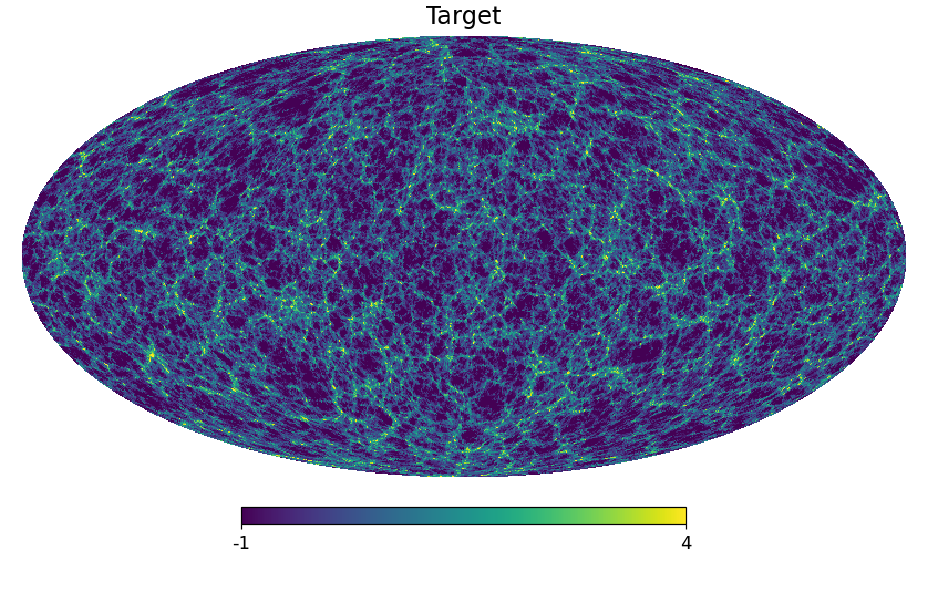

In [12]:
hp.mollview(f_target, min=-1, max=4, title='Target')

<IPython.core.display.Javascript object>


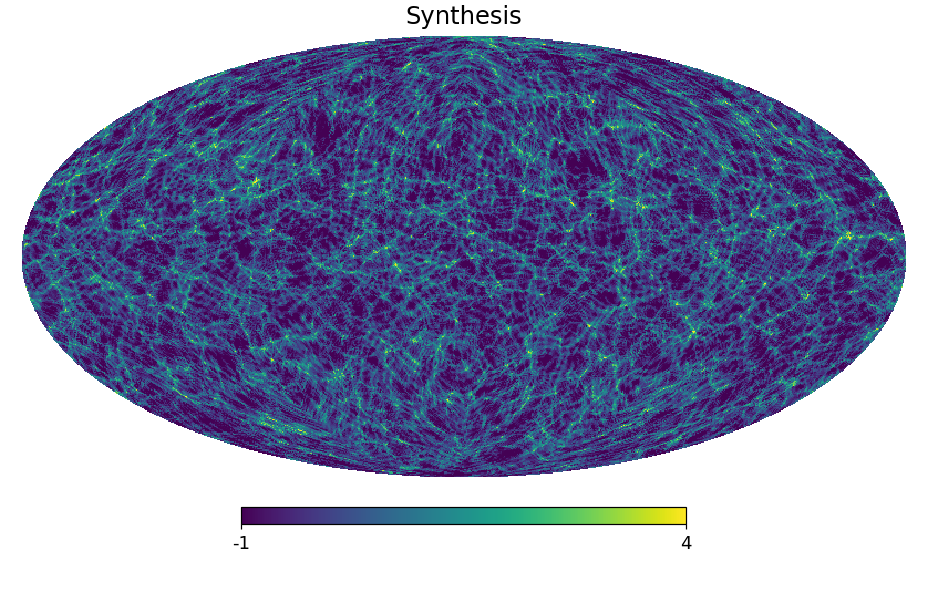

In [13]:
hp.mollview(f_end, min=-1, max=4, title='Synthesis')

# Get the flm

In [14]:
flm_target = s2fft.forward_jax(f_target, L=2*nside, nside=nside, sampling='healpix', reality=False)
flm_end = s2fft.forward_jax(f_end, L=2*nside, nside=nside, sampling='healpix', reality=False)
print(flm_target.shape)

(256, 511)


## Histogram of the Healpix map

In [15]:
def skewness(X):
    mu = np.mean(X)
    std = np.std(X)
    return np.mean(((X-mu) / std)**3)

def kurtosis(X):
    mu = np.mean(X)
    std = np.std(X)
    return np.mean(((X-mu) / std)**4)

tskew = skewness(f_target)
eskew = skewness(f_end)
print(tskew, eskew)

tkurt = kurtosis(f_target)
ekurt = kurtosis(f_end)
print(tkurt, ekurt)

0.7332032873752888 0.6227068285874867
3.82803050738667 3.6134828711306892


<IPython.core.display.Javascript object>


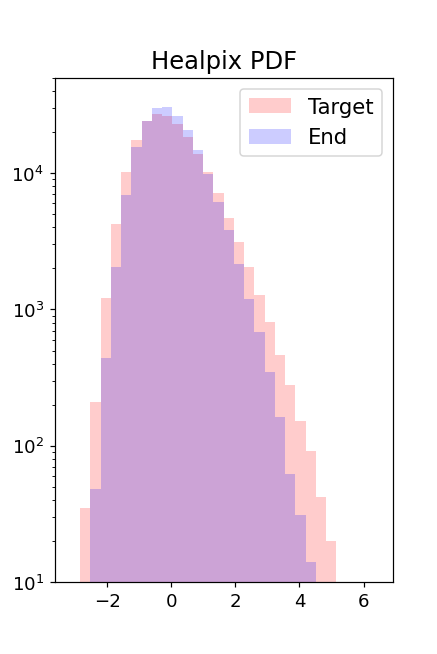

In [17]:
fig, ax0 = plt.subplots(1, 1, figsize=(4, 6))

ax0.hist(f_target, bins=30, range=(f_target.min(), f_target.max()), 
         density=False, color='r', alpha=0.2, label='Target')
ax0.hist(f_end, bins=30, range=(f_target.min(), f_target.max()), 
         density=False, color='b', alpha=0.2, label='End')
#ax0.hist(f_start_hpx, bins=30, density=True, color='g', alpha=0.2, label='Start')
ax0.set_title('Healpix PDF')
ax0.set_yscale("log")
ax0.set_ylim(10, 5e4)
ax0.legend()

## Minkowski

In [115]:
import pynkowski as mf   # For Minkowski Functionals

def make_minkowski(us, map_hpx):

    data = mf.Healpix(map_hpx, normalise=True, mask=None)     # Default parameters
    v0 = mf.V0(data, us)
    v1 = mf.V1(data, us)
    v2 = mf.V2(data, us)
    
    return v0, v1, v2

us = np.arange(-5., 7.01, 0.1)

v0_target, v1_target, v2_target = make_minkowski(us, f_target)
v0_end, v1_end, v2_end = make_minkowski(us, f_end)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


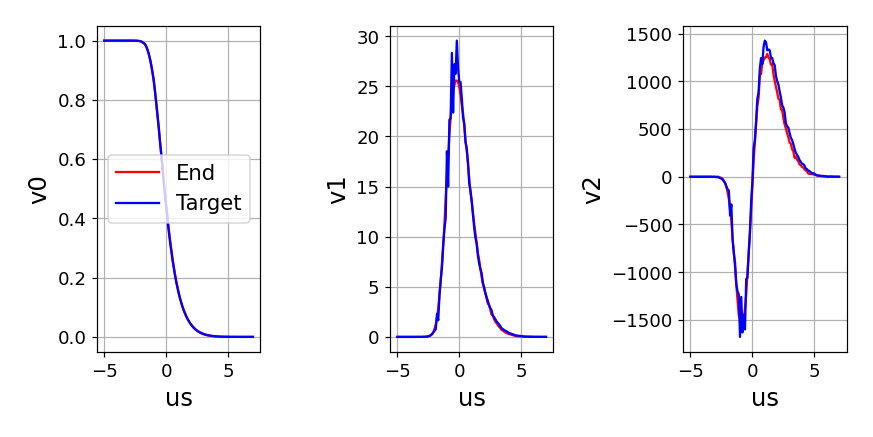

In [116]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))

ax0.plot(us, v0_end, color='r', label='End')
ax0.plot(us, v0_target, color='b', label='Target')
ax0.set_xlabel('us')
ax0.set_ylabel('v0')
ax0.grid()
ax0.legend()

ax1.plot(us, v1_end, color='r', label='End')
ax1.plot(us, v1_target, color='b', label='Target')
ax1.set_xlabel('us')
ax1.set_ylabel('v1')
ax1.grid()
#ax1.legend()

ax2.plot(us, v2_end, color='r', label='End')
ax2.plot(us, v2_target, color='b', label='Target')
ax2.set_xlabel('us')
ax2.set_ylabel('v2')
ax2.grid()
#ax2.legend()

fig.tight_layout()

<IPython.core.display.Javascript object>


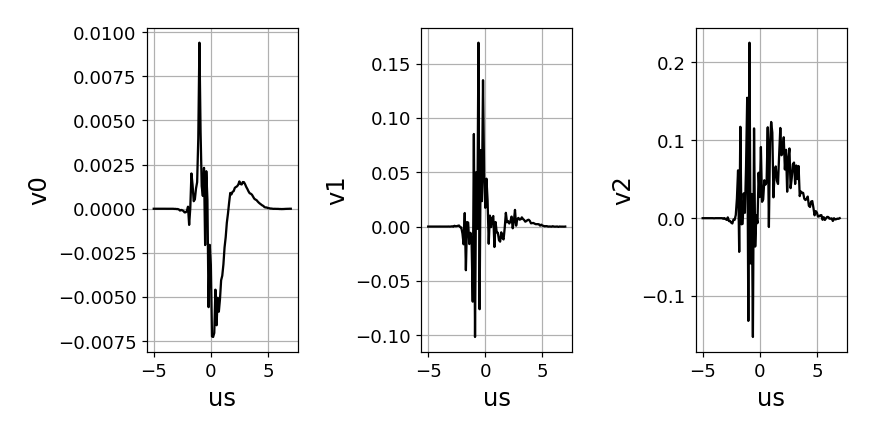

In [117]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))

ax0.plot(us, (v0_target - v0_end)/np.max(v0_target), color='k')
ax0.set_xlabel('us')
ax0.set_ylabel('v0')
ax0.grid()

ax1.plot(us, (v1_target - v1_end)/np.max(v1_target), color='k')
ax1.set_xlabel('us')
ax1.set_ylabel('v1')
ax1.grid()

ax2.plot(us, (v2_target - v2_end)/np.max(v2_target), color='k')
ax2.set_xlabel('us')
ax2.set_ylabel('v2')
ax2.grid()

fig.tight_layout()

## Power spectrum

In [118]:
ps_target = sphlib.compute_ps(flm_target)
ps_end = sphlib.compute_ps(flm_end)

<IPython.core.display.Javascript object>


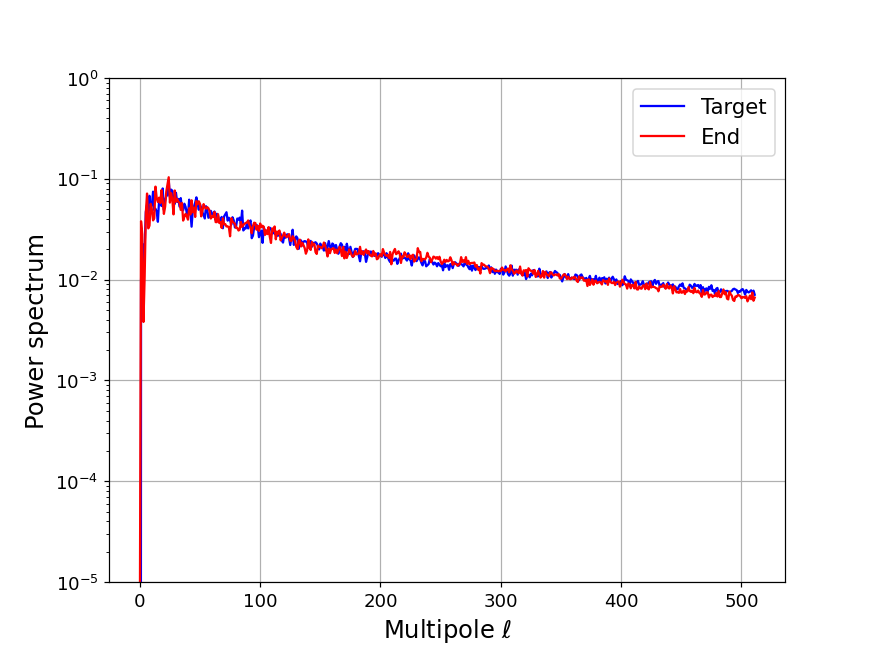

In [119]:
plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_end, 'r', label="End")
plt.yscale("log")
#plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 256)
plt.ylim(1e-5, 1)
plt.legend()

## Scatterings coefficients

In [121]:
sampling = "mw"
multiresolution = True
reality = False

L = 2*nside
N = 2
J_min = 2

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')


J=8 J_max=9


<IPython.core.display.Javascript object>


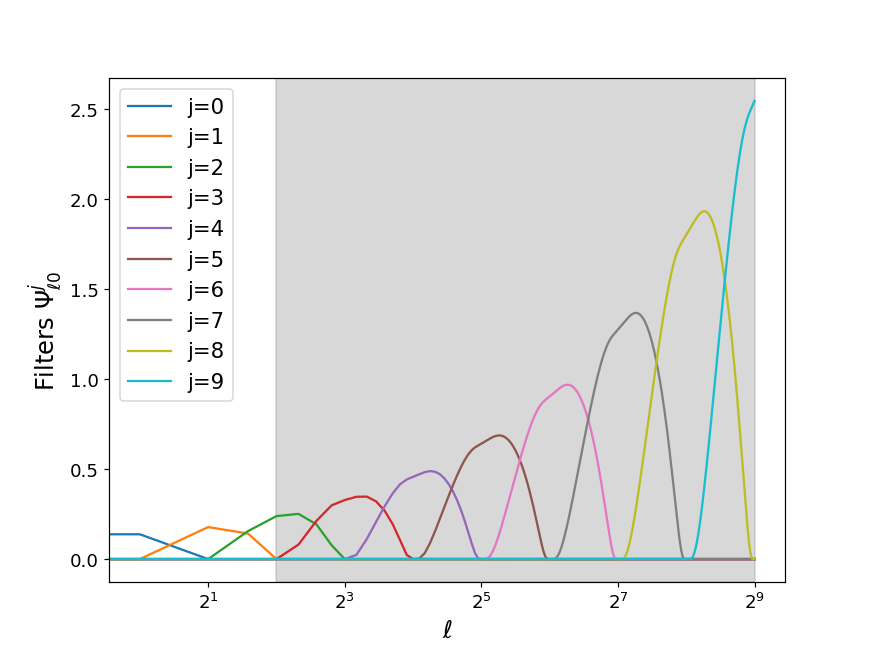

In [122]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=False, m=L-2)
plt.axvspan(2**J_min, 2**J_max, color='grey', alpha=0.3)

# Take the wavelets only, not the scaling function
filters = filters[0]  

In [125]:

weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution)

precomps = s2wav.transforms.jax_wavelets.generate_wigner_precomputes(L, N, J_min, 2.0, sampling, None, False,
                                                                     reality, multiresolution)

In [126]:
### Scat coeffs S1, P00, C01, C11
## Target
tcoeffs = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=None,
                       filters=filters, quads=weights, precomps=precomps)

tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs  # 1D arrays

## Synthesis
ecoeffs = scatlib.scat_cov_dir(flm_end, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=None,
                       filters=filters, quads=weights, precomps=precomps)

emean, evar, eS1, eP00, eC01, eC11 = ecoeffs  # 1D arrays

<IPython.core.display.Javascript object>


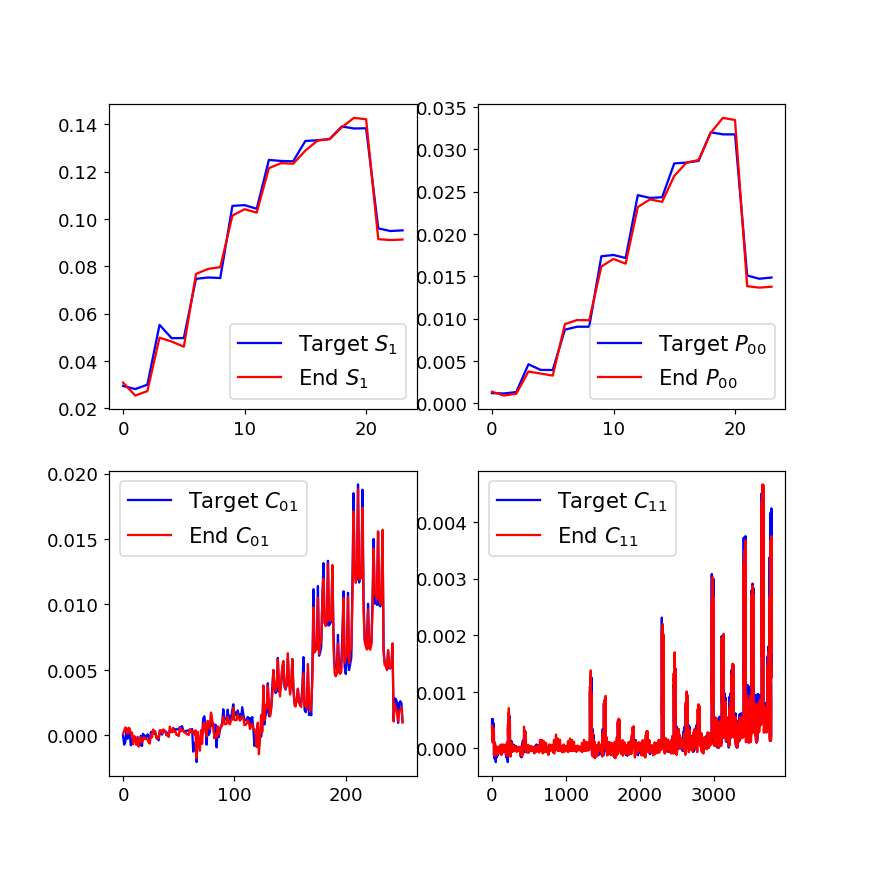

In [127]:
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')
plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')